<a href="https://colab.research.google.com/github/cristiandarioortegayubro/BDS/blob/main/modulo.07/bds_series_temporales_002_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color="DeepPink">Modelos lineales regularizados </font>**

Sabemos que el objetivo de predicción que buscamos es encontrar el valor del próximo periodo en nuestra serie temporal. En terminos formales es encontrar el valor $y_{T+1}$ dado que conocemos $\{y_1, \dots, y_T\}$. Y a esto le podemos agrear información de otros predictores $x_{i,t}, i = 1,\dots , k, t = 1, \dots , T$.

Toda esa información extra que podemos ir agregando para nuestro modelo lo puede convertir en un modelo "ancho" en dónde $k>T$. Estos modelos en dónde la cantidad de variables va en aumento tienen el problema de la "maldición de la dimensionalidad" un problema típico que surge con el "big data". Tengo muchos datos pero también muchas variables explicativas y corremos el riesgo de sobre ajustar el modelo (overfitting).

En el colab anterior fuimos ajustando la cantidad de variables seleccionando cuales eran las variables con las que ibamos a trabajar. Pero... ¿Cómo sabemos que variables seleccionar? ¿Es posible probar todas las combinaciones? ¿Cómo podemos limitar el overfitting?

La regularización nos permite ir disminuyendo la complejidad de los modelos para evitar el sobre ajuste. Son métodos de penalización que se agregan a nuestra función de costo que castigan los modelos demasiado complejos.

## **<font color="DeepPink"> Procesado de datos  </font>**

Vamos a trabajar con una base de datos de la evolución diaria de criptomonedas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
url = "https://raw.githubusercontent.com/pabanib/dataframes/master/criptomonedas/criptos.csv"
criptos = pd.read_csv(url, index_col=0)
criptos.head()

,OpenTime,Open,High,Low,close,Volume,CloseTime,QuoteAssetVol,NumTrades,takerbuybase,takerbuyquote,ignored,token
0,2019-09-18 21:00:00,21.2021,21.5998,20.7415,21.5998,2416.72,2019-09-19 20:59:59.999,51176.899183,568.0,151.22,3233.335502,0.0,BNBBUSD
1,2019-09-19 21:00:00,21.4918,21.5380,20.9728,21.2280,1014.81,2019-09-20 20:59:59.999,21637.032835,334.0,689.47,14745.153511,0.0,BNBBUSD
2,2019-09-20 21:00:00,21.3134,21.4138,20.8128,20.8755,35.59,2019-09-21 20:59:59.999,749.196112,22.0,24.60,517.207235,0.0,BNBBUSD
3,2019-09-21 21:00:00,20.7415,20.7415,20.0146,20.4181,198.81,2019-09-22 20:59:59.999,4059.979917,37.0,105.99,2165.878685,0.0,BNBBUSD
4,2019-09-22 21:00:00,20.3258,20.3258,19.2092,19.3267,804.23,2019-09-23 20:59:59.999,15831.140514,68.0,384.79,7571.610984,0.0,BNBBUSD


La base de datos cuenta con los siguientes datos:

- **OpenTime**: es el horario y día de apertura
- **Open**: Es el valor de apertura de la criptomoneda
- **Close**: es el valor de cierre de
- **Volume**: es el volúmen de operaciones
- **NumTrades**: Es la cantidad de transacciones
- **Token**: Es el par de que se trata la transaccion, las primeras siglas distinguen una criptomoneda las últimas 4 *BUSD* representa la criptomenda con la que se compara.

En total son 50 diferentes tipos de criptomonedas con las que se cuenta, que arrancan en diferentes periodos de tiempo.

Para trabajar de manera más cómoda vamos a transformar los datos en formato panel, esto es, que nos quede un df con un multiíndice copuesto por el token y la fecha de apertura.

In [ ]:
criptos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38688 entries, 0 to 174
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OpenTime       38688 non-null  object 
 1   Open           38688 non-null  float64
 2   High           38688 non-null  float64
 3   Low            38688 non-null  float64
 4   close          38688 non-null  float64
 5   Volume         38688 non-null  float64
 6   CloseTime      38688 non-null  object 
 7   QuoteAssetVol  38688 non-null  float64
 8   NumTrades      38688 non-null  float64
 9   takerbuybase   38688 non-null  float64
 10  takerbuyquote  38688 non-null  float64
 11  ignored        38688 non-null  float64
 12  token          38688 non-null  object 
dtypes: float64(10), object(3)
memory usage: 4.1+ MB


In [ ]:
# convertimos la columna OpenTime en una serie de tipo Timestamp
criptos.OpenTime = pd.to_datetime(criptos.OpenTime)
# cambiamos el índice por un multiindice
crip = criptos.set_index(['token','OpenTime'])
# eliminamos algunas variables
crip= crip.drop(['CloseTime','ignored','takerbuybase','takerbuyquote'], axis = 1)
crip.head()

Open     High      Low    close   Volume  \
token   OpenTime                                                           
BNBBUSD 2019-09-18 21:00:00  21.2021  21.5998  20.7415  21.5998  2416.72   
        2019-09-19 21:00:00  21.4918  21.5380  20.9728  21.2280  1014.81   
        2019-09-20 21:00:00  21.3134  21.4138  20.8128  20.8755    35.59   
        2019-09-21 21:00:00  20.7415  20.7415  20.0146  20.4181   198.81   
        2019-09-22 21:00:00  20.3258  20.3258  19.2092  19.3267   804.23   

                             QuoteAssetVol  NumTrades  
token   OpenTime                                       
BNBBUSD 2019-09-18 21:00:00   51176.899183      568.0  
        2019-09-19 21:00:00   21637.032835      334.0  
        2019-09-20 21:00:00     749.196112       22.0  
        2019-09-21 21:00:00    4059.979917       37.0  
        2019-09-22 21:00:00   15831.140514       68.0

Nos vamos a enfocar en predecir el precio del bitcoin, por lo tanto vamos a filtrar el dataset

<Axes: xlabel='OpenTime'>

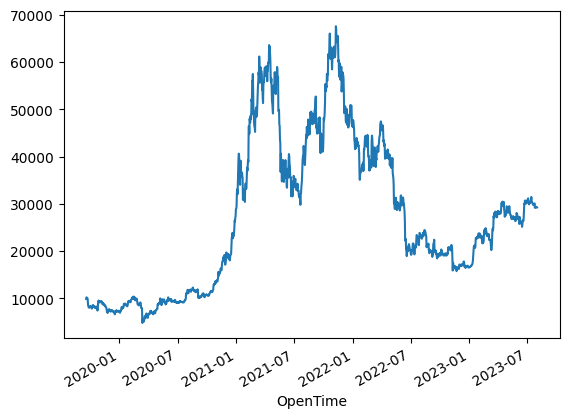

In [ ]:
btc = crip.loc['BTCBUSD']
btc.Open.plot()

La del bitcoin es la serie más larga junto a algunas otras que se encuentran. El movimiento es diario y parte desde el 18/09/2019. Lo que nos suma un total de 1413 periodos. Ya estamos ante mucha más cantidad de datos de los que veníamos trbajando además de una frecuencia alta del movimiento, ya que lo tomamos por día.

Vamos a predecir el precio de cierre (Close), todas las otras variables van a ser variables predictivas con los lags correspondientes.

In [ ]:
y = btc.close
y

OpenTime
2019-09-18 21:00:00    10254.92
2019-09-19 21:00:00    10171.06
2019-09-20 21:00:00     9998.87
2019-09-21 21:00:00    10010.53
2019-09-22 21:00:00     9706.93
                         ...   
2023-07-27 21:00:00    29315.02
2023-07-28 21:00:00    29355.11
2023-07-29 21:00:00    29281.38
2023-07-30 21:00:00    29234.03
2023-07-31 21:00:00    29200.01
Name: close, Length: 1413, dtype: float64

In [ ]:
def gen_lags(var, ini = 1, fin = 60, nom = ''):
  X = []
  nombres = []
  for i in range(ini,fin):
    v = var.shift(i)
    X.append(v)
    nombres.append(nom+'lag'+str(i))

  X = pd.concat(X, axis = 1)
  X.columns = nombres
  return X

def aplicar_col(df, nom,*args,**kwargs):
  dfs = []
  for c in df.columns:
    d = gen_lags(df[c],nom = nom+'_'+c+'_', *args, **kwargs )
    dfs.append(d)
  return pd.concat(dfs, axis = 1)

x_btc = aplicar_col(btc,'btc')
x_btc


,btc_Open_lag1,btc_Open_lag2,btc_Open_lag3,btc_Open_lag4,btc_Open_lag5,btc_Open_lag6,btc_Open_lag7,btc_Open_lag8,btc_Open_lag9,btc_Open_lag10,...,btc_NumTrades_lag50,btc_NumTrades_lag51,btc_NumTrades_lag52,btc_NumTrades_lag53,btc_NumTrades_lag54,btc_NumTrades_lag55,btc_NumTrades_lag56,btc_NumTrades_lag57,btc_NumTrades_lag58,btc_NumTrades_lag59
OpenTime,,,,,,,,,,,,,,,,,,,,,
2019-09-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 21:00:00,9881.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-20 21:00:00,10214.31,9881.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-21 21:00:00,10169.44,10214.31,9881.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-22 21:00:00,9928.07,10169.44,10214.31,9881.43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27 21:00:00,29353.43,29228.00,29180.00,30087.11,29790.84,29906.00,29807.22,29913.66,29862.03,30146.01,...,112321.0,204934.0,197772.0,210612.0,67321.0,62172.0,139132.0,131275.0,161031.0,131701.0
2023-07-28 21:00:00,29220.95,29353.43,29228.00,29180.00,30087.11,29790.84,29906.00,29807.22,29913.66,29862.03,...,100869.0,112321.0,204934.0,197772.0,210612.0,67321.0,62172.0,139132.0,131275.0,161031.0
2023-07-29 21:00:00,29315.02,29220.95,29353.43,29228.00,29180.00,30087.11,29790.84,29906.00,29807.22,29913.66,...,240662.0,100869.0,112321.0,204934.0,197772.0,210612.0,67321.0,62172.0,139132.0,131275.0


Nos ha quedado un df de 413 predictores ya que genera los rezagos por cada una de las variables. Pero agreguemos algunas otras variables más que representen el día de la semana y el mes.

In [ ]:
x_btc['d_semana'] = y.index.day_name()
x_btc['mes'] = y.index.month_name()
x_btc['dia'] = y.index.day

Ahora vamos a eliminar todos aquellos periodos nulos y limpiamos también la variable y.

In [ ]:
x_btc = x_btc.dropna()
inicio = x_btc.index[0]
y = y.loc[inicio:]
len(y) == len(x_btc)

True

Como también tenemos información que proviene de todo el resto de criptomonedas que se opera, la vamos a utilizar porque puede ser relevante, o no, recordemos que nuestro objetivo es minimizar la función de costo.

Primero vamos a emparjear las series, sabemos que muchas de las criptomonedas que se encuentran en la base no tienen el mismo largo en periodos, pero vamos a completar a todas con valores 0, como que todavía no empiezan a operar.

In [ ]:
# eliminamos el btc que ya lo trabajamos
crip2 = crip.drop('BTCBUSD')
# ahora desapilamos los datos de manera que cada criptomoneda sea parte de las columnas
# de esta manera nos aseguramos que todas van a tener el mismo largo y las completamos con 0
crip2 = crip2.unstack(0).fillna(0)
# luego volvemos a apilar los datos como estaban
crip2 = crip2.stack(1).unstack(0).stack(1)


<ipython-input-10-75e1d9e10f2e>:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  crip2 = crip.drop('BTCBUSD')


Luego de emparejar el largo de las series vamos a proceder a generar los respectivos rezagos por cada criptomoneda y todo pasarlo como variables predictivas del precio de cierre del btc.

In [ ]:
dfs_crip = []
for c in crip2.index.get_level_values(0).unique():
  df = crip2.loc[c]
  d = aplicar_col(df,c,fin = 20)
  dfs_crip.append(d)

dfs = pd.concat(dfs_crip, axis = 1)
dfs.head()


,ACHBUSD_High_lag1,ACHBUSD_High_lag2,ACHBUSD_High_lag3,ACHBUSD_High_lag4,ACHBUSD_High_lag5,ACHBUSD_High_lag6,ACHBUSD_High_lag7,ACHBUSD_High_lag8,ACHBUSD_High_lag9,ACHBUSD_High_lag10,...,XRPBUSD_close_lag10,XRPBUSD_close_lag11,XRPBUSD_close_lag12,XRPBUSD_close_lag13,XRPBUSD_close_lag14,XRPBUSD_close_lag15,XRPBUSD_close_lag16,XRPBUSD_close_lag17,XRPBUSD_close_lag18,XRPBUSD_close_lag19
OpenTime,,,,,,,,,,,,,,,,,,,,,
2019-09-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-20 21:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-21 21:00:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-22 21:00:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ahora resta unir este dataframe con el que ya habíamos construido y nos qeude todo en uno solo. También remplazaremos los valores nulos por 0 así no nos genera problemas.

In [ ]:
X = pd.merge(x_btc, dfs, left_index = True, right_index= True)
X = X.dropna()
X.shape

(1354, 6933)

Luego de todos estos pasos podemos ver que nos quedaron 20653 variables explicativas contra 1354 observaciones. Realmente tenemos un $k>T$ y un gran riesgo de overfitting. ¿Cómo trabajamos esto?

# **<font color="DeepPink"> Modelos regularizados </font>**

## **<font color="DeepPink"> Regresión Ridge </font>**

Cuando tenemos el caso como el anterior, podemos recurrir a la regularización. La idea que sigue la regularización es llevar los predictores a $0$. Cuando el coeficiente de una variable predictiva se acerca a $0$ significa que esa variable no influye en la determinación de nuestra variable objetivo. Supongamos que tenemos el siguiente modelo:
$$ y=\mu+\beta x+u;$$

dónde $y$ es la variable que queremos explicar, $x$ la variable explicativa, $\mu$ el intercepto y $u$ los residuos. Si  $\beta = 0$ entonces vamos a tener que: $E(y|x) = E(y) = \mu$. Lo que significa que $x$ no explica a $y$.

Los modelos de regularización lo que hacen es precismente ir llevando los coeficientes de las variables menos importantes a $0$. La regresión ridge tiene una penalización cuadrática y se escribe de la siguiente forma:

\begin{equation}
\hat{\beta}^{ridge} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2 + λ\sum_{j=1}^p\beta_j^2\right\}
\end{equation}

Acá $x_{ij}$ puede ser cualquier predictor, sea un rezago o una variable exógena. El parámetro $\lambda$ o hiperparámetro es el regularizador de esta función que se va seleccionar con validación cruzada. Como se puede ver la forma del estimadr es la cuadrática de mínimos cuadrados más una parte de penalización.

La regresión ridge no es invariante a las escalas de los parámetros, es por eso que se deben estandarizar las variables previo a hacer los cálculos.


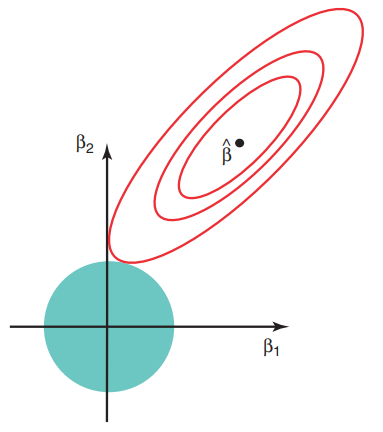

## **<font color="DeepPink"> LASSO  </font>**

La regresión LASSO es muy similar a la ridge, la diferencia es que se cambia la penalización $L2$ (el cuadrdado de los parámetros)  por la penalización $L1$ (valor absoluto de los parámetros).


\begin{equation}
\hat{\beta}^{lasso} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2 + λ\sum_{j=1}^p|\beta_j|\right\}
\end{equation}

La restricción de esta regresión lleva los parametros $\beta$ hacia 0 anulando los que no son relevantes para la solución del problema, a diferencia de la ridge que se acerca a 0 asintóticamente. Esta regresión es muy útil para la selección de variables es por eso que ultimamente es más utilizada que la ridge.

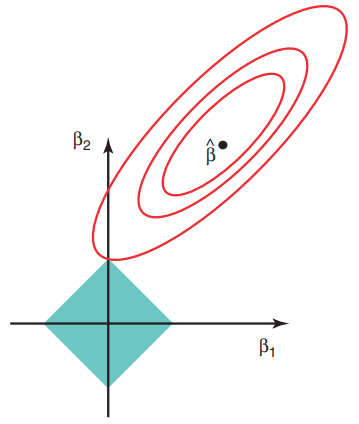

## **<font color="DeepPink"> Elastic net  </font>**

El método *elastic net* junta las penalizaciones $L1$ y $L2$ en un solo algoritmo. La fórmula del estimador quedaría de la siguiente forma:

\begin{equation}
\hat{\beta}^{en} = argmin_β\left\{\left(y_i-\beta_0-\sum_{j=1}^p\beta_j^2x_{ij}\right)^2 + (1-\alpha) λ\sum_{j=1}^p\beta_j^2+\alpha\lambda\sum_{j=1}^p|\beta_j|\right\}
\end{equation}

Es muy similar a los anteriores solo que ajusta con un parámetro $\alpha$ a cual penalización le da más importancia, LASSO y ridge son casos particulares de elastic net cuando $\alpha = 1$ y cuando $\alpha = 0$ respectivamente.



# **<font color="DeepPink"> Aplicación </font>**

Vamos a proceder a aplicar los modelos anteriores al caso que venimos trabajando. Hemos llegado a obtener el df que queremos trabajar pero aún nos falta aplicar preprocesamiento de datos que lo haremos con scikit learn

In [ ]:
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

np.random.seed(4651)

Con los métodos <code>PowerTransformer()</code> podemos suavizar las variables como si fuera logaritmos, pero a diferencia de estos, nos permite trabajar con valores $0$.

In [ ]:
pw = PowerTransformer(method = 'yeo-johnson', standardize = True)
# a la variable objetivo la vamos a convertir en logaritmo
y = np.log(y)

In [ ]:
x_btc.columns

Index(['btc_Open_lag1', 'btc_Open_lag2', 'btc_Open_lag3', 'btc_Open_lag4',
       'btc_Open_lag5', 'btc_Open_lag6', 'btc_Open_lag7', 'btc_Open_lag8',
       'btc_Open_lag9', 'btc_Open_lag10',
       ...
       'btc_NumTrades_lag53', 'btc_NumTrades_lag54', 'btc_NumTrades_lag55',
       'btc_NumTrades_lag56', 'btc_NumTrades_lag57', 'btc_NumTrades_lag58',
       'btc_NumTrades_lag59', 'd_semana', 'mes', 'dia'],
      dtype='object', length=416)

Procedemos a crear el pipline que trabaje los datos

In [ ]:
colum_num = list(X.columns)
colum_num.remove('d_semana')
colum_num.remove('mes')
colum_num.remove('dia')
colum_cate = ['d_semana', 'mes', 'dia']

pipe = ColumnTransformer(
    [("num", pw, colum_num),
     ('cate', OneHotEncoder(),colum_cate)
    ])

X_transf = pipe.fit_transform(X)


In [ ]:
porc_ent = 0.9
ind = int(len(X_transf)*porc_ent)

X_train, y_train = X_transf[:ind], y[:ind]
X_test, y_test = X_transf[ind:], y[ind:]

mod_lin = LinearRegression()
mod_lin.fit(X_train, y_train)

alpha = 0.01
ridge = Ridge( alpha = alpha)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha = alpha)
lasso.fit(X_train, y_train)

enet = ElasticNet(alpha = alpha, l1_ratio = 0.5)
enet.fit(X_train,y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.860e-02, tolerance: 5.748e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e-01, tolerance: 5.748e-02
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.01)

In [ ]:
from sklearn.metrics import mean_squared_error

modelos = [mod_lin, ridge, lasso, enet]
nomb = ['mod_lin', 'ridge', 'lasso', 'enet']

result = {}
for i in range(4):
  mod = modelos[i]
  mse_train = mean_squared_error(y_train, mod.predict(X_train))
  mse_test = mean_squared_error(y_test, mod.predict(X_test))
  res = {}
  res['mse_train'] = mse_train
  res['mse_test'] = mse_test
  result[nomb[i]] = res

pd.DataFrame(result).T


,mse_train,mse_test
mod_lin,1.796375e-29,0.081226
ridge,2.050824e-08,0.080056
lasso,2.545943e-03,0.005498
enet,2.402027e-03,0.006461


Como podemos ver el mse con los datos de entrenamiento es más bajo para los modelos que no regularizan o regularizan más débil como son el modelo lineal(no regulariza) y el modelo ridge (no elimina variables). Pero cuando probamos su predicción en los datos de testeo la diferencia es muy favorable para los que regularizan más fuerte.

In [ ]:
coeficientes = {}
for i in range(4):
  mod = modelos[i]
  res = {}
  res['prom'] = mod.coef_.mean()
  res['No ceros'] = np.sum(mod.coef_ != 0)
  res['prom no cero'] = (mod.coef_[mod.coef_ != 0]).mean()
  res['max v.a.'] = np.abs(mod.coef_).max()
  coeficientes[nomb[i]] = res

pd.DataFrame(coeficientes).T



,prom,No ceros,prom no cero,max v.a.
mod_lin,0.000079,6980.0,0.000079,0.038527
ridge,0.000079,6980.0,0.000079,0.038307
lasso,0.000097,39.0,0.017301,0.327962
enet,0.000100,55.0,0.012655,0.199714


Si observamos el comportamiento de los coeficientes podemos  ver las diferencias que producen los diferentes modelos en estos. En el promedio de coeficientes al ser tantos todos tienen valores muy bajos, pero los valores más altos del promedio son en Lasso y Elasticnet, que regularizan más fuerte. Por otro lado la cantidad de coeficientes que son distintos de cero hay notable diferencia. Lasso deja solo 29 coeficientes con un promedio de ellos de 0.022 y un máximo valor de 0.335 lo que muestra que lso coeficientes tienen mucho más peso en este modelo.

## **<font color="DeepPink"> Evaluamos con validación cruzada  </font>**

In [ ]:
tss = TimeSeriesSplit()

In [ ]:
 from sklearn.model_selection import GridSearchCV

In [ ]:

params = {'alpha' : [0.0001, 0.001, 0.01,0.1]}
params_en = {'alpha' : [0.0001, 0.001, 0.01,0.1],
          'l1_ratio': [0.5,0.8]
          }
params

{'alpha': [0.0001, 0.001, 0.01, 0.1]}

In [ ]:
ridge_grid = GridSearchCV(ridge, params,cv = tss, scoring = 'neg_mean_squared_error')
lasso_grid = GridSearchCV(lasso, params,cv = tss, scoring = 'neg_mean_squared_error')
enet_grid = GridSearchCV(enet, params_en, cv = tss, scoring = 'neg_mean_squared_error')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

ridge_grid.fit(X_train,y_train)
lasso_grid.fit(X_train,y_train)
enet_grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(alpha=0.01),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'l1_ratio': [0.5, 0.8]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_grid.best_params_,lasso_grid.best_params_, enet_grid.best_params_

({'alpha': 0.1}, {'alpha': 0.001}, {'alpha': 0.001, 'l1_ratio': 0.8})

In [ ]:
np.array((ridge_grid.best_score_,lasso_grid.best_score_, enet_grid.best_score_))*-1

array([0.28069796, 0.02807912, 0.02742675])

In [ ]:
modelos = [ridge_grid,lasso_grid, enet_grid]
nomb2 = nomb[1:]
predic = {}
scores = {}
for i in range(3):
  m = modelos[i]
  pred = m.best_estimator_.predict(X_test)
  res = {}
  res['mse_cv'] = m.best_score_
  res['mse_test'] = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(pred)))
  scores[nomb2[i]] = res
  predic[nomb2[i]] = pred

In [ ]:
pd.DataFrame(scores).T

,mse_cv,mse_test
ridge,-0.280698,6876.182957
lasso,-0.028079,2496.189096
enet,-0.027427,2589.809797


<Axes: title={'center': 'Predicciones del BTC'}>

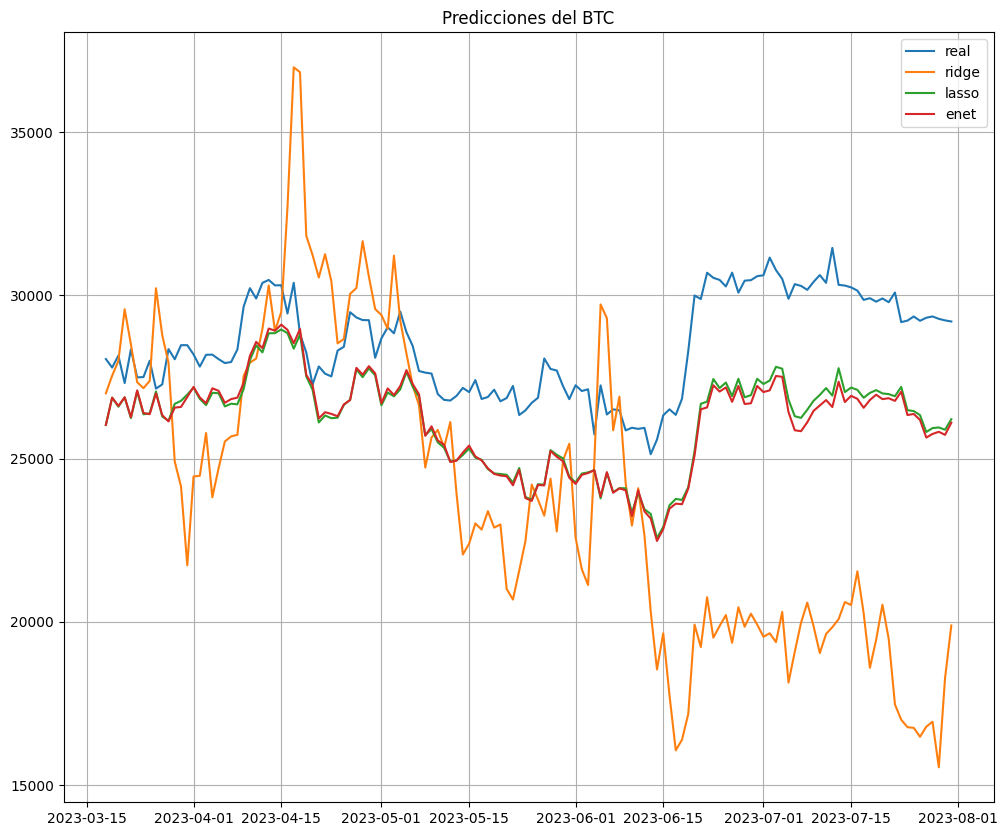

In [ ]:
col = ['real']
col.extend(nomb2)
Predic = pd.DataFrame(np.exp(np.c_[y_test.values, predic['ridge'],predic['lasso'],predic['enet']]), index = y_test.index.date, columns = col)
Predic.plot(figsize = (12,10), grid = True,
            title = 'Predicciones del BTC'
            )


In [ ]:
lasso_grid.cv_results_

{'mean_fit_time': array([3.35228801, 3.39017878, 2.49451437, 3.32369184]),
 'std_fit_time': array([2.24555273, 2.25393268, 1.94841794, 3.37395576]),
 'mean_score_time': array([0.00797915, 0.00529594, 0.00341921, 0.00376635]),
 'std_score_time': array([0.00325319, 0.00188765, 0.00031816, 0.00048657]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1}],
 'split0_test_score': array([-0.06049028, -0.10764487, -0.10348883, -0.26509813]),
 'split1_test_score': array([-0.20467651, -0.01099692, -0.1674575 , -1.21283693]),
 'split2_test_score': array([-0.02787044, -0.01248423, -0.00966822, -0.11506321]),
 'split3_test_score': array([-0.02464684, -0.00279588, -0.00272051, -0.01354671]),
 'split4_test_score': array([-0.00586571, -0.00647372, -0.00307451, -0.00265137]),
 'mean_test_score': array([-0.0

In [ ]:
column_names = list(pipe.named_transformers_['num'].get_feature_names_out(colum_num) )
column_names.extend(pipe.named_transformers_['cate'].get_feature_names_out(colum_cate))
len(column_names)

6980

In [ ]:
coef_lasso = lasso_grid.best_estimator_.coef_[lasso_grid.best_estimator_.coef_ != 0]

pd.Series(coef_lasso, index = np.array(column_names)[lasso_grid.best_estimator_.coef_ != 0]).sort_values(ascending = False)[:50]

btc_close_lag1             0.252570
btc_High_lag1              0.193057
btc_Low_lag1               0.078343
LTCBUSD_close_lag1         0.057369
FILBUSD_Low_lag19          0.020671
ACHBUSD_Low_lag13          0.010170
MATICBUSD_Volume_lag1      0.009347
DOTBUSD_Volume_lag2        0.008659
SOLBUSD_Volume_lag19       0.007636
EURBUSD_NumTrades_lag10    0.007369
btc_NumTrades_lag56        0.007045
LTCBUSD_Low_lag1           0.006665
FTTBUSD_close_lag4         0.006600
EURBUSD_Low_lag3           0.006368
LUNABUSD_Volume_lag16      0.006057
MATICBUSD_Volume_lag7      0.005939
LUNABUSD_Volume_lag17      0.005783
btc_NumTrades_lag54        0.005580
NEARBUSD_Volume_lag3       0.004809
FTTBUSD_Low_lag4           0.004450
AVAXBUSD_Volume_lag2       0.004267
LUNABUSD_Volume_lag2       0.004240
NEARBUSD_Volume_lag8       0.004189
SOLBUSD_Volume_lag17       0.004173
NEARBUSD_Volume_lag2       0.004117
DOGEBUSD_Volume_lag1       0.003554
NEARBUSD_Volume_lag4       0.003523
EURBUSD_High_lag8          0

In [ ]:
coef_enet = enet_grid.best_estimator_.coef_[enet_grid.best_estimator_.coef_ != 0]

pd.Series(coef_enet, index = np.array(column_names)[enet_grid.best_estimator_.coef_ != 0]).sort_values(ascending = False)[:50]

btc_close_lag1             0.227569
btc_High_lag1              0.203698
btc_Low_lag1               0.081328
LTCBUSD_close_lag1         0.063683
FILBUSD_Low_lag19          0.017291
DOTBUSD_Volume_lag2        0.010711
MATICBUSD_Volume_lag1      0.009787
ACHBUSD_Low_lag13          0.008860
EURBUSD_NumTrades_lag10    0.008593
LTCBUSD_Low_lag1           0.008377
AVAXBUSD_Volume_lag2       0.007767
btc_NumTrades_lag56        0.007363
SOLBUSD_Volume_lag19       0.007325
LUNABUSD_Volume_lag16      0.005926
EURBUSD_Low_lag3           0.005799
LUNABUSD_Volume_lag17      0.005750
btc_NumTrades_lag54        0.005693
MATICBUSD_Volume_lag7      0.005225
FILBUSD_Open_lag19         0.005003
NEARBUSD_Volume_lag3       0.004815
FTTBUSD_close_lag4         0.004751
SOLBUSD_Volume_lag17       0.004734
FTTBUSD_Low_lag9           0.004364
EURBUSD_High_lag8          0.004249
XRPBUSD_Volume_lag7        0.004067
COCOSBUSD_Low_lag15        0.004053
NEARBUSD_Volume_lag8       0.004011
DOGEBUSD_Volume_lag1       0

# **<font color="DeepPink"> Predcir más de un periodo  </font>**

Supongamos que estamos interesados en predecir un rango de periodos más largo que solo el próximo. Llamemoslé a este lapso $h$. Nuestro problema quedaría ahora de la siguiente forma:

$$\hat{y}_{T+h|T}= \mathcal{f}\left(y_T,\dots ,y_1, x_{1,1},\dots , x_{1,T},\dots ,x_{k,T}\right),$$

La diferencia que tenemos al predecir este nuevo modelo es que nuestra variable objetivo ahora es una matriz $T \times h$ y nuestro estimador va quedar de tamaño $\hat{β}_{k \times h}$ lo que también va ser una matriz, pero la forma de optimizar los modelos va ser la misma.

In [ ]:
btc

,Open,High,Low,close,Volume,QuoteAssetVol,NumTrades
OpenTime,,,,,,,
2019-09-18 21:00:00,9881.43,10305.58,9828.59,10254.92,1.051048,1.060699e+04,112.0
2019-09-19 21:00:00,10214.31,10233.53,10078.91,10171.06,6.916184,7.021372e+04,196.0
2019-09-20 21:00:00,10169.44,10169.44,9940.27,9998.87,3.053031,3.048605e+04,72.0
2019-09-21 21:00:00,9928.07,10050.12,9874.30,10010.53,1.797653,1.785481e+04,57.0
2019-09-22 21:00:00,10037.70,10037.70,9612.75,9706.93,28.145778,2.749258e+05,669.0
...,...,...,...,...,...,...,...
2023-07-27 21:00:00,29220.95,29545.58,29132.48,29315.02,1711.407790,5.014965e+07,47855.0
2023-07-28 21:00:00,29315.02,29408.83,29259.23,29355.11,675.509500,1.981077e+07,33477.0
2023-07-29 21:00:00,29355.11,29448.87,29036.66,29281.38,1270.393930,3.716099e+07,44654.0


In [ ]:
h = 7
#utilizamos la función y generamos una matriz con h rezagos
y_h = aplicar_col(btc[['close']], 'y',ini = 0, fin = h)
y_h

,y_close_lag0,y_close_lag1,y_close_lag2,y_close_lag3,y_close_lag4,y_close_lag5,y_close_lag6
OpenTime,,,,,,,
2019-09-18 21:00:00,10254.92,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 21:00:00,10171.06,10254.92,NaN,NaN,NaN,NaN,NaN
2019-09-20 21:00:00,9998.87,10171.06,10254.92,NaN,NaN,NaN,NaN
2019-09-21 21:00:00,10010.53,9998.87,10171.06,10254.92,NaN,NaN,NaN
2019-09-22 21:00:00,9706.93,10010.53,9998.87,10171.06,10254.92,NaN,NaN
...,...,...,...,...,...,...,...
2023-07-27 21:00:00,29315.02,29222.20,29353.44,29228.01,29180.00,30088.00,29790.84
2023-07-28 21:00:00,29355.11,29315.02,29222.20,29353.44,29228.01,29180.00,30088.00
2023-07-29 21:00:00,29281.38,29355.11,29315.02,29222.20,29353.44,29228.01,29180.00


In [ ]:

x_btc_h = aplicar_col(btc, 'btc', ini = h, fin = 20+h)
x_btc_h

,btc_Open_lag7,btc_Open_lag8,btc_Open_lag9,btc_Open_lag10,btc_Open_lag11,btc_Open_lag12,btc_Open_lag13,btc_Open_lag14,btc_Open_lag15,btc_Open_lag16,...,btc_NumTrades_lag17,btc_NumTrades_lag18,btc_NumTrades_lag19,btc_NumTrades_lag20,btc_NumTrades_lag21,btc_NumTrades_lag22,btc_NumTrades_lag23,btc_NumTrades_lag24,btc_NumTrades_lag25,btc_NumTrades_lag26
OpenTime,,,,,,,,,,,,,,,,,,,,,
2019-09-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-20 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-21 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-22 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27 21:00:00,29807.22,29913.66,29862.03,30146.01,30247.37,30301.09,30322.58,31455.77,30385.15,30622.00,...,82658.0,94443.0,44138.0,40135.0,88363.0,168131.0,84551.0,79558.0,101357.0,74078.0
2023-07-28 21:00:00,29906.00,29807.22,29913.66,29862.03,30146.01,30247.37,30301.09,30322.58,31455.77,30385.15,...,87266.0,82658.0,94443.0,44138.0,40135.0,88363.0,168131.0,84551.0,79558.0,101357.0
2023-07-29 21:00:00,29790.84,29906.00,29807.22,29913.66,29862.03,30146.01,30247.37,30301.09,30322.58,31455.77,...,160078.0,87266.0,82658.0,94443.0,44138.0,40135.0,88363.0,168131.0,84551.0,79558.0


In [ ]:
x_btc_h['d_semana'] = y_h.index.day_name()
x_btc_h['mes'] = y_h.index.month_name()
x_btc_h['dia'] = y_h.index.day

x_btc_h = x_btc_h.dropna()
inicio = x_btc_h.index[0]
y_h = y_h.loc[inicio:]
len(y_h) == len(x_btc_h)


True

In [ ]:
dfs_crip = []
for c in crip2.index.get_level_values(0).unique():
  df = crip2.loc[c]
  d = aplicar_col(df,c,ini = h,fin = 20+h)
  dfs_crip.append(d)

dfs = pd.concat(dfs_crip, axis = 1)
X = pd.merge(x_btc_h, dfs, left_index = True, right_index= True)
X = X.dropna()
X.shape

(1387, 7003)

In [ ]:
colum_num = list(X.columns)
colum_num.remove('d_semana')
colum_num.remove('mes')
colum_num.remove('dia')
colum_cate = ['d_semana', 'mes', 'dia']

pipe = ColumnTransformer(
    [("num", pw, colum_num),
     ('cate', OneHotEncoder(),colum_cate)
    ])

X_transf = pipe.fit_transform(X)

y_h = np.log(y_h)

In [ ]:
porc_ent = 0.9
ind = int(len(X_transf)*porc_ent)

X_train, y_train = X_transf[:ind], y_h[:ind]
X_test, y_test = X_transf[ind:], y_h[ind:]


In [ ]:
params = {'alpha' : [0.0001, 0.001, 0.01,0.1],
          'l1_ratio': [0,0.5,0.8,1]
          }

In [ ]:

lasso = Lasso(alpha = 0.01)

In [ ]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

In [ ]:
index = y_test.index
pred = lasso.predict(X_test)
columnas = y_test.columns

dfs = []
for i in range(7):
  yy = y_test.values[:,i]
  pred_ = pred[:,i]
  d = pd.DataFrame(np.c_[yy,pred_], index = index, columns = [columnas[i],columnas[i]+'_pred'])
  dfs.append(d)

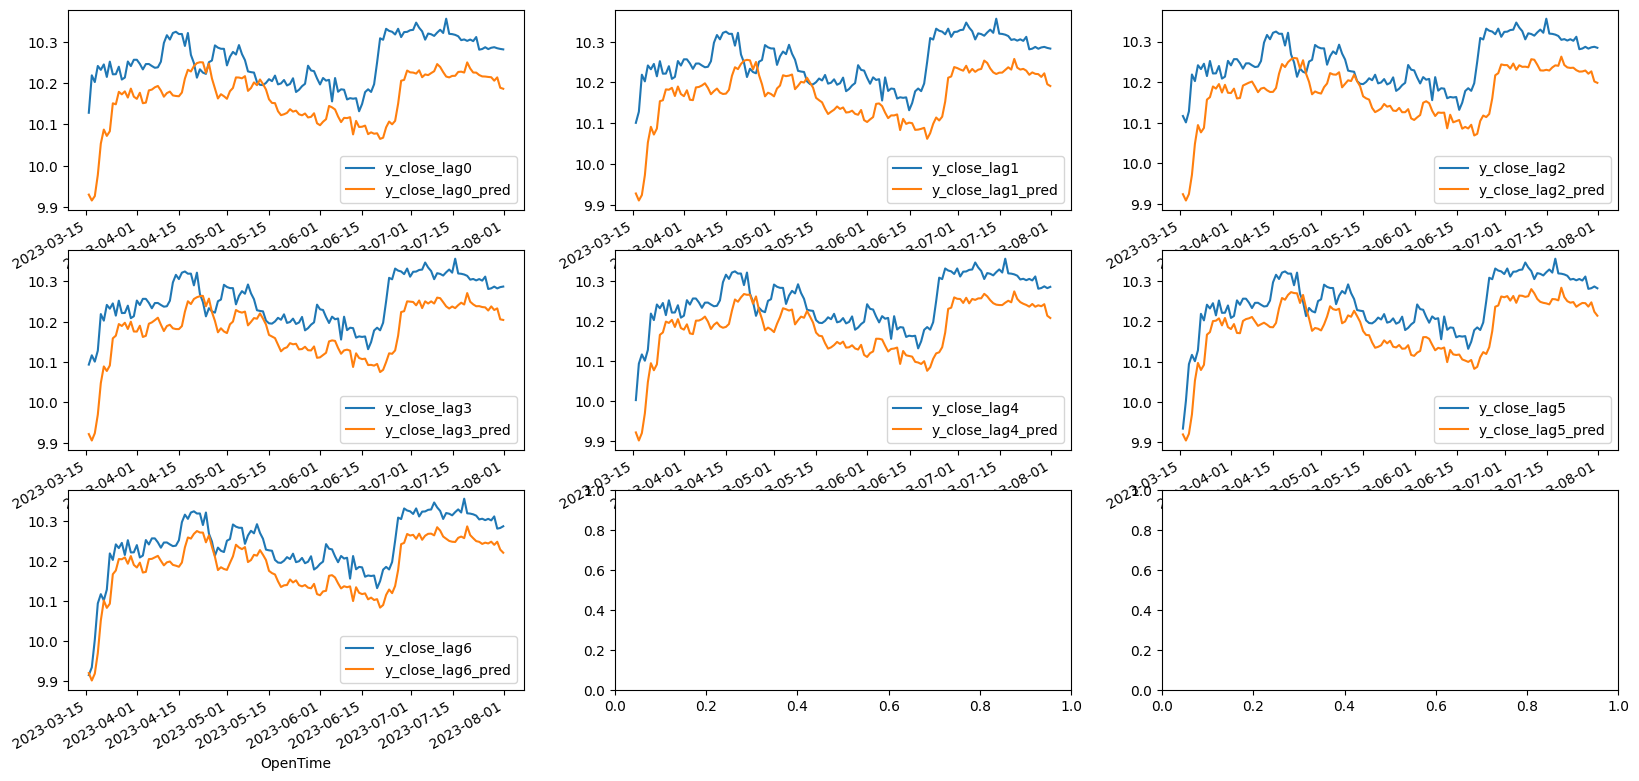

In [ ]:
fig, ax = plt.subplots(nrows = int(h/3)+1, ncols = 3, figsize = (20,10))

i = 0
for f in range(3):
  for c in range(3):
    if i < h:
      dfs[i].plot(ax = ax[f,c])
      i += 1
    else:
      break


In [ ]:
np.exp(lasso.predict(X_test[-1].reshape(1,-1)))

array([[26542.5133458 , 26671.31055111, 26861.92405631, 27023.75009674,
        27118.19802054, 27292.6574851 , 27469.18879581]])

In [ ]:
enet_grid = GridSearchCV(enet, params, cv = tss, scoring = 'neg_mean_squared_error')
#enet_grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(alpha=0.01),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'l1_ratio': [0, 0.5, 0.8, 1]},
             scoring='neg_mean_squared_error')

In [ ]:
enet_grid.best_score_

-0.06999236297434039

In [ ]:
index = y_test.index
pred = enet_grid.best_estimator_.predict(X_test)
columnas = y_test.columns

dfs = []
for i in range(7):
  yy = y_test.values[:,i]
  pred_ = pred[:,i]
  d = pd.DataFrame(np.c_[yy,pred_], index = index, columns = [columnas[i],columnas[i]+'_pred'])
  dfs.append(d)

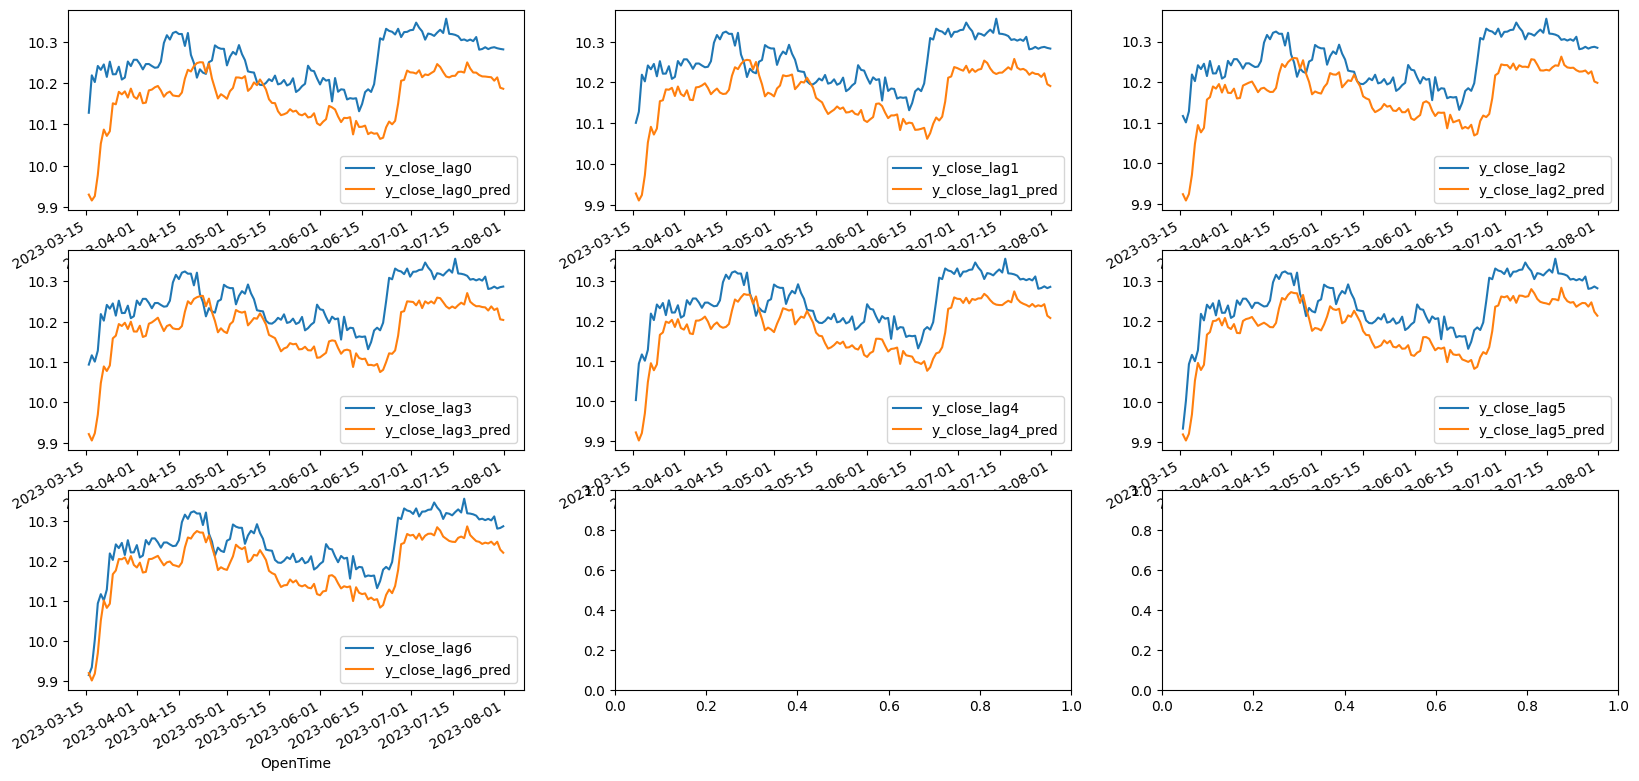

In [ ]:
fig, ax = plt.subplots(nrows = int(h/3)+1, ncols = 3, figsize = (20,10))

i = 0
for f in range(3):
  for c in range(3):
    if i < h:
      dfs[i].plot(ax = ax[f,c])
      i += 1
    else:
      break